<a href="https://colab.research.google.com/github/ashishar/q_character/blob/main/Brahmi_with_qnn_and_qat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torchvision
# !pip install qiskit-machine-learning
import importlib

# Check if torchvision is installed
try:
    importlib.import_module('torchvision')
    print("torchvision is already installed.")
except ImportError:
    print("torchvision is not installed. Installing...")
    # Install torchvision using pip
    try:
        import pip
        pip.main(['install', 'torchvision'])
        print("torchvision installed successfully.")
    except Exception as e:
        print("Error occurred while installing torchvision:", str(e))

# try:
#     importlib.import_module('qiskit')
#     print("qiskit is already installed.")
# except ImportError:
#     print("qiskit is not installed. Installing...")
#     # Install torchvision using pip
#     try:
#         import pip
#         pip.main(['install', 'qiskit'])
#         print("qiskit installed successfully.")
#     except Exception as e:
#         print("Error occurred while installing qiskit:", str(e))

# try:
#     importlib.import_module('qiskit_machine_learning')
#     print("qiskit-machine-learning is already installed.")
# except ImportError:
#     print("qiskit-machine-learning is not installed. Installing...")
#     # Install torchvision using pip
#     try:
#         import pip
#         pip.main(['install', 'qiskit-machine-learning'])
#         print("qiskit-machine-learning installed successfully.")
#     except Exception as e:
#         print("Error occurred while installing qiskit-machine-learning:", str(e))


torchvision is already installed.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Change directory to the desired location where the file is stored.
%cd /content/drive/MyDrive/

# Import the file named quantum_circuit_simulator.py
#import quantum_circuit_simulator


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [4]:
import torch
import math



def get_device(gpu_no):
    if torch.cuda.is_available():
        return torch.device('cuda', gpu_no)
    else:
        return torch.device('cpu')






class quantum_circuit:

    def __init__(self, num_qubits : int, state_vector = None, device = 'cuda', gpu_no = 0):

        """
        Defines a quantum circuit object that stores the full state-vector (evolved through
        the unitary operations of a quantum circuit) of `num_qubits` number of qubits.

        Args:
            num_qubits (int): Number of qubits in the circuit.

            state_vector (torch.Tensor, optional): The full state vector of the quantum circuit.
                                          Defaults to None. If None is provided then the state
                                          vector is automatically initialized to the ket |0000...0>.

            device (str, optional): Device on which the state vector should be stored (CPU / GPU).
                                    Defaults to 'cuda' i.e. GPU.

            gpu_no (int, optional): If there are multiple GPUs then this parameter defines which
                                    GPU to use. Defaults to 0 i.e. the first device.
        """
        #----------------------------------------------------------------------------------------

        if device != 'cuda':
            self.device = torch.device(device)
        else:
            self.device = get_device(gpu_no)


        #----------------------------------------------------------------------------------------


        self.n = num_qubits   # number of qubits
        self.dim = 2**self.n  # dimention of the n-qubit hilbert space


        #----------------------------------------------------------------------------------------

        '''
        state_vector can
        (1) either be a vector of shape (dim,)
        (2) either be a matrix of shape (dim, number of examples)
        '''

        if state_vector is None:
            ''' Initialize the state-vector to |0000...0> '''
            state_vector = torch.zeros(self.dim, device=self.device, dtype=torch.cfloat)
            state_vector[0] = 1
            self.state_vector = state_vector.reshape(-1,1)
        else:
            if state_vector.shape[0] == self.dim:
                ''' state_vector must be normalized '''
                self.state_vector = state_vector.to(torch.cfloat)
            else:
                print('The dimension 2**n does NOT match the shape of the state vector. n is the number of qubits.')


        #----------------------------------------------------------------------------------------

        # single qubit Pauli gates (matrices) :
        self.I        = torch.tensor([[1,   0], [0,  1]], device=self.device, dtype=torch.cfloat)
        self.x_matrix = torch.tensor([[0.,  1], [1,  0]], device=self.device, dtype=torch.cfloat)
        self.y_matrix = torch.tensor([[0, -1j], [1j, 0]], device=self.device, dtype=torch.cfloat)
        self.z_matrix = torch.tensor([[1,   0], [0, -1]], device=self.device, dtype=torch.cfloat)

        self.h_matrix = (1 / math.sqrt(2)) * torch.tensor([[1, 1], [1, -1]], device=self.device, dtype=torch.cfloat)


        # single qubit projectors :
        self.proj_0 = torch.tensor([[1, 0], [0, 0]], device=self.device, dtype=torch.cfloat)
        self.proj_1 = torch.tensor([[0, 0], [0, 1]], device=self.device, dtype=torch.cfloat)



   #======================================================================================================



    def single_qubit_gate(self, target : int, gate : torch.Tensor):
        """
        Applies a single qubit gate = I ⊗ I ⊗ ... ⊗ gate ⊗ ... ⊗ I

        Args:
        target (int): The qubit index on which the gate will be applied
        gate (torch.Tensor): The matrix representation of a single qubit gate

        Returns:
        The state vector of the full quantum circuit after applying the single qubit gate.

        """

        if target < 0 or self.n <= target:
            print('0 <= traget <= num_qubits - 1 is NOT satisfied!')

        else:
            single_q_gate = torch.tensor(1, device=self.device, dtype=torch.cfloat) # initialize

            for k in range(self.n):
                if k == target:
                    single_q_gate = torch.kron(single_q_gate, gate)
                else:
                    single_q_gate = torch.kron(single_q_gate, self.I)

            #------------------------------------------------------

            self.state_vector = torch.matmul(single_q_gate, self.state_vector)
            return self.state_vector




    def controlled_gate(self, control: int, target: int, gate : torch.Tensor):
        """
        Applies a two-qubit controlled gate between the 'control` and `target` qubits.

        control_gate_part_0 = I ⊗ |0><0| ⊗ ... ⊗ I    ⊗ ... ⊗ I
        control_gate_part_1 = I ⊗ |1><1| ⊗ ... ⊗ gate ⊗ ... ⊗ I         SEE: the control is set to 1

        control_gate = control_gate_part_0 + control_gate_part_1


        Args:
        control (int): Control qubit index
        target (int):  Target qubit index
        gate (torch.Tensor): The matrix representation of a single qubit gate

        Returns:
        The state vector of the full quantum circuit after applying the two-qubit gate.
        """

        if control < 0 or self.n <= control:
            print('0 <= control <= num_qubits - 1 is NOT satisfied!')
        elif target < 0 or self.n <= target:
            print('0 <= target <= num_qubits - 1 is NOT satisfied!')
        elif control == target:
            print('control and traget qubits must be different!')
        else:
            control_gate_part_0 = torch.tensor(1, device=self.device, dtype=torch.cfloat) # initialize
            control_gate_part_1 = torch.tensor(1, device=self.device, dtype=torch.cfloat)

            for k in range(self.n):
                if k == control:
                    control_gate_part_0 = torch.kron(control_gate_part_0, self.proj_0)
                    control_gate_part_1 = torch.kron(control_gate_part_1, self.proj_1)
                elif k == target:
                    control_gate_part_0 = torch.kron(control_gate_part_0, self.I)
                    control_gate_part_1 = torch.kron(control_gate_part_1, gate)
                else:
                    control_gate_part_0 = torch.kron(control_gate_part_0, self.I)
                    control_gate_part_1 = torch.kron(control_gate_part_1, self.I)

            control_gate = control_gate_part_0 + control_gate_part_1

            self.state_vector = torch.matmul(control_gate, self.state_vector)
            return self.state_vector


    #======================================================================================================

    def x(self, target : int):                           # Applies X gate (matrix) on the target qubit
        'NOTE: 0 <= target <= num_qubits - 1'
        self.single_qubit_gate(target, self.x_matrix)


    def y(self, target : int):
        self.single_qubit_gate(target, self.y_matrix)


    def z(self, target : int):
        self.single_qubit_gate(target, self.z_matrix)


    def h(self, target : int):                           # Applies Hadamard gate (matrix) on the target qubit
        self.single_qubit_gate(target, self.h_matrix)


   #======================================================================================================


    def Rx(self, target : int, theta):

        """
        Applies Rx gate (rotation around x axis) on the target qubit

        Args:
        theta (torch.Tensor): Angle by which the qubit should be rotated around X axis.
                              Usually a tunable parameter is passed.

        target (int): Qubit index on which the Rx gate will be applied.
        NOTE: 0 <= target <= num_qubits - 1
        """

        co = torch.cos(theta / 2)
        si = torch.sin(theta / 2)
        self.Rx_matrix = torch.stack([torch.stack([co, -1j*si]), torch.stack([-1j*si, co])])

        self.single_qubit_gate(target, self.Rx_matrix)




    def Ry(self, target : int, theta):            #like Rx, Ry gate applies (rotation around y axis) on the target qubit

        co = torch.cos(theta / 2)
        si = torch.sin(theta / 2)
        self.Ry_matrix = torch.stack([torch.stack([co, -si]), torch.stack([si, co])])

        self.single_qubit_gate(target, self.Ry_matrix)





    def Rz(self, target : int, theta):            #like Rx, Ry gate applies (rotation around z axis) on the target qubit

        exp_theta = torch.exp( 1j*theta )
        zero = torch.tensor(0)
        one = torch.tensor(1)
        self.Rz_matrix = torch.stack([torch.stack([one, zero]), torch.stack([zero, exp_theta])])

        self.single_qubit_gate(target, self.Rz_matrix)




    def R(self, target : int, theta, phi, lamda):
        """
        Applies general rotation to the target qubit

        Args:
        theta, phi and lamda (torch.Tensor): The Euler angles which define a general rotation around Bloch sphere.

        target (int): Qubit index on which the gate will be applied.
        """

        a =                                  torch.cos(theta / 2)
        b =        - torch.exp(1j * lamda) * torch.sin(theta / 2)
        c =            torch.exp(1j * phi) * torch.sin(theta / 2)
        d =  torch.exp(1j * (phi + lamda)) * torch.cos(theta / 2)
        self.R_matrix = torch.stack([torch.stack([a, b]), torch.stack([c, d])])

        self.single_qubit_gate(target, self.R_matrix)


    #======================================================================================================


    def Ry_layer(self, angs: torch.Tensor):
        '''
        Applies tensor-product of single-qubit rotations around y-axis
        '''

        cos, sin = torch.cos(angs[0]), torch.sin(angs[0])
        '''
        Use torch.stack otherwise computation graph will be broken (or will not begin).
        And, grad will be gone (will not be stored).
        '''
        rot = torch.stack([torch.stack([cos, -sin]), torch.stack([sin, cos])])

        for i in range(1, len(angs)):                                    # one angles for each qubit
            cos, sin = torch.cos(angs[i]), torch.sin(angs[i])
            rot = torch.kron(rot, torch.stack([torch.stack([cos, -sin]), torch.stack([sin, cos])]))

        #--------------------------------------------------------------------------

        self.state_vector = torch.matmul(rot, self.state_vector)      # rotated state vector
        return self.state_vector





    def Rz_layer(self, angs: torch.Tensor):       #like Ry_layer, Rz_layer acts

        exp_ang = torch.exp( 1j*angs[0] )
        zero = torch.tensor(0)
        one = torch.tensor(1)

        rot = torch.stack([torch.stack([one, zero]), torch.stack([zero, exp_ang])])

        for i in range(1, len(angs)):                                    # one angles for each qubit
            exp_ang = torch.exp( 1j*angs[i] )
            rot = torch.kron(rot, torch.stack([torch.stack([one, zero]), torch.stack([zero, exp_ang])]) )

        #--------------------------------------------------------------------------

        self.state_vector = torch.matmul(rot, self.state_vector)      # rotated state vector
        return self.state_vector



    #======================================================================================================

    def cx(self, control: int, target: int):
        """
        Applies controlled-X gate = I ⊗ |0><0| ⊗ ... ⊗ I ⊗ ... ⊗ I +
                                    I ⊗ |1><1| ⊗ ... ⊗ X ⊗ ... ⊗ I

        Args:
        control (int): Control qubit index
        target (int):  Target qubit index
        """
        self.controlled_gate(control, target, self.x_matrix)




    def cz(self, control: int, target: int):                           #like cx, cz gate acts
        self.controlled_gate(control, target, self.z_matrix)



   #======================================================================================================


    def cx_linear_layer(self):
        '''
        Applies cx(n-1,n) ... cx(2,3) cx(1,2) cx(0,1) |state_vector>

        NOTE: First cx(0,1) will act on |state_vector>, then cx(1,2)
              And in the last cx(n-1,n) will act.
              order matter in case of cx
        '''

        self.controlled_gate(self.n - 2, self.n - 1, self.x_matrix)
        for i in range(self.n - 3, -1, -1):
            self.controlled_gate(i, i+1, self.x_matrix)



    def cz_linear_layer(self):                                        #like cx_linear_layer, cz_linear_layer  acts
        self.controlled_gate(self.n - 2, self.n - 1, self.z_matrix)
        for i in range(self.n - 3, -1, -1):
            self.controlled_gate(i, i+1, self.z_matrix)


   #======================================================================================================

    def probabilities(self):
        """
        probabilities obtained in the z-measurement (computational basis) on the state vector

        Returns: A torch.Tensor of the size same as the state vector
        """

        return self.state_vector.conj() * self.state_vector


In [5]:
# prompt: I want to download devanagari character dataset from Kaggle.

#!pip install kaggle
#!mkdir -p ~/.kaggle
#!cp /content/drive/MyDrive/brahmi/kaggle.json ~/.kaggle/kaggle.json
#!kaggle datasets download --force -d gautamneha/brahmi-dataset
!unzip "/content/drive/My Drive/brahmi-dataset.zip" -d "/content/data"

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/test/117/26.jpg  
  inflating: /content/data/test/117/27.jpg  
  inflating: /content/data/test/117/28.jpg  
  inflating: /content/data/test/117/29.jpg  
  inflating: /content/data/test/117/30.jpg  
  inflating: /content/data/test/118/26.jpg  
  inflating: /content/data/test/118/27.jpg  
  inflating: /content/data/test/118/28.jpg  
  inflating: /content/data/test/118/29.jpg  
  inflating: /content/data/test/118/30.jpg  
  inflating: /content/data/test/119/26.jpg  
  inflating: /content/data/test/119/27.jpg  
  inflating: /content/data/test/119/28.jpg  
  inflating: /content/data/test/119/29.jpg  
  inflating: /content/data/test/119/30.jpg  
  inflating: /content/data/test/12/1.jpg  
  inflating: /content/data/test/12/11.jpg  
  inflating: /content/data/test/12/15.jpg  
  inflating: /content/data/test/12/18.jpg  
  inflating: /content/data/test/12/22.jpg  
  inflating: /content/data/test/120/26.jpg  
  inflatin

In [6]:
#!pip install Pillow

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset


# Step 1: Define the transforms for the training and testing data
train_transforms = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to a common size
    #transforms.Grayscale(num_output_channels=1),
    #transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

test_transforms = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize to a common size
    #transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Step 2: Load the datasets using ImageFolder
train_dataset = datasets.ImageFolder(root='/content/data/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='/content/data/test', transform=test_transforms)

train_images = []
train_labels = []

# Iterate through the dataset
for img, label in train_dataset:
    train_images.append(img)
    train_labels.append(label)

# Convert lists to tensors
train_images_tensor = torch.stack(train_images)  # Stacks all image tensors
train_labels = torch.tensor(train_labels)  # Converts label list to tensor

# Define weights for the RGB channels
weights = torch.tensor([0.2989, 0.5870, 0.1140]).view(1, 3, 1, 1)

# Ensure the weights tensor is on the same device as the images tensor
if train_images_tensor.is_cuda:
    weights = weights.cuda()

# Convert RGB to grayscale
train_images = (train_images_tensor * weights).sum(dim=1, keepdim=True)
train_images=  train_images.squeeze(1)

# Create a train in TensorDataset
train_dataset = TensorDataset(train_images, train_labels)

# Check the shape of the output
# Check the shapes
print(f"Train Images Tensor: {train_images.shape}")  # Expected: [num_samples, channels, height, width]
print(f"Train Labels Tensor: {train_labels.shape}")  # Expected: [num_samples] # Should be [4250, 28, 28]
print("Train_dataset ",len(train_dataset))


test_images = []
test_labels = []

# Iterate through the dataset
for img, label in test_dataset:
    test_images.append(img)
    test_labels.append(label)

# Convert lists to tensors
test_images_tensor = torch.stack(test_images)  # Stacks all image tensors
test_labels = torch.tensor(test_labels)  # Converts label list to tensor

# Convert RGB to grayscale
test_images = (test_images_tensor * weights).sum(dim=1, keepdim=True)
test_images =  test_images.squeeze(1)

# Check the shape of the output
# Check the shapes
print(f"Test Images Tensor: {test_images.shape}")  # Expected: [num_samples, channels, height, width]
print(f"Test Labels Tensor: {test_labels.shape}")  # Expected: [num_samples] # Should be [850, 28,28]

# Create a TensorDataset
test_dataset = TensorDataset(test_images, test_labels)
print("test_dataset ",len(test_dataset))

# # Example: Iterate over the train_loader
# for images, labels in train_loader:
#     print(images.shape, labels.shape)
#     break  # Break after the first batch to show an example

batch_size=64
# # Step 3: Create the data loaders to batch and shuffle the data
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# train_loader=train_loader.squeeze(1)
# test_loader=test_loader.squeeze(1)

Train Images Tensor: torch.Size([4250, 28, 28])
Train Labels Tensor: torch.Size([4250])
Train_dataset  4250
Test Images Tensor: torch.Size([850, 28, 28])
Test Labels Tensor: torch.Size([850])
test_dataset  850


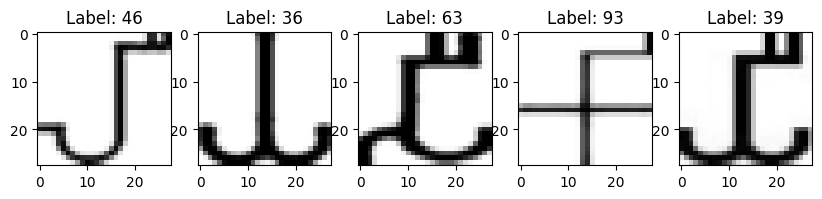

In [8]:
import matplotlib.pyplot as plt

# Plotting function
def plot_images(images, labels, num_images=5):
  fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
  for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f'Label: {labels[i]}')
    ax.axis('on')
  plt.show()

# Display the first 5 images and labels
for features, labels in train_loader:
  plot_images(features, labels, 5)
  break  # Only process the first batch#


In [9]:
unique_labels = torch.unique(train_labels)
num_unique_labels = len(unique_labels)
print(f"Number of unique labels: {num_unique_labels}")

Number of unique labels: 170


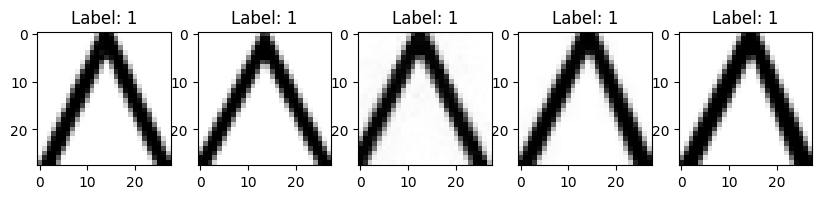

In [10]:
from torch.utils.data import TensorDataset
from IPython.display import display, clear_output
import time


def plot_images_by_label(dataloader, specific_label, num_images=5):
    count = 0  # Counter to track how many images we have displayed
    plt.figure(figsize=(10, 2))  # Set up the figure size

    for images, labels in dataloader:
        for image, label in zip(images, labels):
            if label.item() == specific_label:  # Check if the label matches
                count += 1
                ax = plt.subplot(1, num_images, count)  # Create a subplot for each image
                ax.imshow(image.squeeze(), cmap='gray')  # Display image, squeeze() is used to remove extra dimensions if any
                ax.title.set_text(f'Label: {label.item()}')
                ax.axis('on')  # Turn off axis

                if count == num_images:  # Only display a specific number of images
                    plt.show()
                    return
# Example usage
# Assuming your DataLoader, images, and labels are properly set up
# Here you call the function with the label you want to display and the number of images

for i in range(2):
  plot_images_by_label(train_loader, specific_label=i, num_images=5)# Call the function with the desired label
  clear_output(wait=True)  # Clear the current output and wait for new output
  time.sleep(0.01)  # Pause for a second to simulate time taken in an iteration



In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"    # Get gpu or cpu device for training
print(f"Using {device} device\n")


import torch.nn as nn
import torchvision.transforms.functional as TF
from skimage.feature import hog
from quantum_circuit_simulator import quantum_circuit
import numpy as np
import torch.quantization
import torch.optim as optim

def quantize_angles(angles, num_levels=16):
    """
    Quantizes angles to a discrete set of levels.

    :param angles: Tensor of angles to quantize.
    :param num_levels: Number of discrete levels to use for quantization.
    :return: Quantized angles.
    """
    # Normalize angles between -π and π
    angles = torch.remainder(angles + torch.pi, 2 * torch.pi) - torch.pi
    # Define quantization levels
    step_size = 2 * torch.pi / num_levels
    quantized_angles = torch.round(angles / step_size) * step_size
    return quantized_angles


# Define a function to compute HOG features for an image
def compute_hog_features(image):
    features, _ = hog(image, orientations=12, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    return features

#=====================================================================================


class QNN(torch.nn.Module):                              # Define model
    def __init__(self, n, L):                            # number of qubits = n, number of quantum layers = L
        super().__init__()

        self.flatten = nn.Flatten()

        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)
        self.angles = torch.nn.Parameter(angles)                   # it makes angles learnable parameters
        self.num_levels=128

        # self.fc1 = nn.Linear(1024, 1024)
        # self.fc2 = nn.Linear(784,512)
        # self.fc3 = nn.Linear(512, 1024)

        self.linear1 = nn.Linear(2**n, 256)                          # classical linear layer
        self.linear2 = nn.Linear(256,170)                          # classical linear layer


    def forward(self, x):
        #x = F.pad(x, (2 ,2, 2, 2), "constant", 0)                  # (left, right, top, bottom) padding
        x_projection = torch.sum(x, dim=1).to(device)  # Calculate x-axis projection
        #x_projection = x_projection / torch.norm(x_projection, p=1)
        #print("x projection ",x_projection.shape)
        y_projection = torch.sum(x, dim=2).to(device)  # Calculate x-axis projection
        #print("y projection ",y_projection.shape)
        #y_projection = y_projection / torch.norm(y_projection, p=1)
        #angle projection
        rotated_images1 = TF.rotate(x,30).to(device)
        rotated_images2 = TF.rotate(x,45).to(device)
        rotated_images3 = TF.rotate(x,60).to(device)

        #rotated projections
        rotated_projection1=torch.sum(rotated_images1, dim=2).to(device)
        rotated_projection2=torch.sum(rotated_images2, dim=2).to(device)
        rotated_projection3=torch.sum(rotated_images3, dim=2).to(device)

        #rotated_images = torch.sum(torch.stack([TF.rotate(img, angle) for img in inputs]))
        x_image=x.cpu().numpy()
        hog_features = [compute_hog_features(np.squeeze(image)) for image in x_image]
        hog_features_tensor = torch.tensor(np.array(hog_features), dtype=torch.float32).to(device)
        #print(hog_features_tensor.shape)

        x = self.flatten(x)
        x = x[:, :-92]

        # print("sizes ",x.shape, y_projection.shape, rotated_projection1.shape,rotated_projection2.shape,
        #      rotated_projection3.shape,hog_features_tensor.shape)

        combined_projection=torch.cat((x,x_projection,y_projection, rotated_projection1,rotated_projection2,rotated_projection3,#rotated_projection4.squeeze(),rotated_projection5.squeeze(),rotated_projection6.squeeze(),
                                       hog_features_tensor), dim=1)
        #print(x.shape, " ",hog_features_tensor.shape)
        #torch.zeros(x.shape[0],100).to(device)
        #print("combined ", combined_projection.shape)
        #x = self.flatten(x)
        combined_projection /= torch.linalg.norm(x.clone(), ord=2, dim=1, keepdim=True)   # L2 normalization to change x --> |x⟩

        # combined_projection = torch.sigmoid(self.fc1(combined_projection))
        # x1 = torch.sigmoid(self.fc2(x1))
        # x1 = torch.sigmoid(self.fc3(x1))

        '''initializing parameterized quantum circuits (PQC)'''

        qc = quantum_circuit(num_qubits = n, state_vector = combined_projection.T)   # each column is a feature-vector of an example
        for l in range(L):
          quantized_weights = quantize_angles(self.angles[l],self.num_levels)
          #outputs = quantum_circuit(inputs, quantized_weights)
          qc.Ry_layer(quantized_weights.to(torch.cfloat))           # rotation part of lth quantum layer
          #qc.cx_linear_layer()                                   # entangling part of lth quantum layer

        'after passing through the PQC, measurement on the output-ket in the computational basis'
        x = torch.real(qc.probabilities())               # each column is a probabilities-vector for an example
                                                         # x.shape = (dim, batch size)

        #print(torch.sum(x, dim=0))                      # to see whether probabilities add up to 1 or not

        x = self.linear1(x.T)                            # x.shape = (batch size, 10),  classical linear layer
        x= self.linear2(x)
        return x

Using cuda device



In [16]:
def performance_estimate(dataset, model, loss_fn, train_or_test):
    '''this function computes accuracy and loss of a model on the training or test set'''
    data_size = len(dataset)

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(dataloader)

    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            accuracy += (pred.argmax(1) == y).sum().item()
            loss += loss_fn(pred, y).item()
    accuracy /= data_size                                            # accuracy lies in the interval [0, 1]
    loss /= num_batches
    print(f"{train_or_test} accuracy: {round(accuracy, 3)},  {train_or_test} loss: {round(loss,3)}")
    return accuracy, loss




def one_epoch(model, loss_fn, optimizer, train_dataset, test_dataset, batch_size):

    A_train, L_train, A_test, L_test = [], [], [], []

    dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass
        loss = loss_fn(out, y)

        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients


        if batch % batch_size == 0:
            #As training progress, computing and appending loss and accuracy of the model on train and test set
            accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
            accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
            print()

            A_train.append(accuracy_train)
            L_train.append(loss_train)
            A_test.append(accuracy_test)
            L_test.append(loss_test)

            #print(f"train loss: {round(loss,3)}")

    return A_train, L_train, A_test, L_test



def training(train_dataset, test_dataset, batch_size, n, L, lr_, weight_decay_, epochs):

    model = QNN(n=n, L=L).to(device)
    model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

    model = torch.quantization.prepare_qat(model)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)

    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs):
        print(f"Epoch {t+1} ---------------------------------- \n")
        #As training progress, computing and appending loss and accuracy of the model on train and test set
        A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, train_dataset, test_dataset, batch_size)
        A_Train += A_train
        L_Train += L_train
        A_Test += A_test
        L_Test += L_test

        #accuracy, loss = performance_estimate(test_dataset, model, loss_fn, 'test ')

    model_state_dict = model.state_dict()           # for saving or loading the trained model

    return A_Train, L_Train, A_Test, L_Test, model_state_dict

In [18]:
%%time

n = 10
dim = 2**n              # dimension of the n-qubit Hilbert space
L = 3

n_angs = n*L

print("number of qubits = ", n)
print("number of quantum layers = ", L)
print(f"number of angles (learnable parameters of quantum circuit) = {n_angs}\n ")

#--------------------------------------------------------------------------------------


batch_size = 64
print(f'batch_size = {batch_size}\n')


#----------------------------------------------------------------------------------


A_Train, L_Train, A_Test, L_Test, model_state_dict = training(train_dataset, test_dataset, batch_size=batch_size, n=n, L=L,
                                                              lr_=0.01/10, weight_decay_=1e-10, epochs=25)


print(f' ~~~~~ training is done ~~~~~\n')

number of qubits =  10
number of quantum layers =  3
number of angles (learnable parameters of quantum circuit) = 30
 
batch_size = 64

Epoch 1 ---------------------------------- 

train accuracy: 0.016,  train loss: 5.132
test  accuracy: 0.008,  test  loss: 5.133

train accuracy: 0.345,  train loss: 4.452
test  accuracy: 0.322,  test  loss: 4.435

Epoch 2 ---------------------------------- 

train accuracy: 0.392,  train loss: 4.374
test  accuracy: 0.379,  test  loss: 4.378

train accuracy: 0.537,  train loss: 3.276
test  accuracy: 0.508,  test  loss: 3.268

Epoch 3 ---------------------------------- 

train accuracy: 0.566,  train loss: 3.186
test  accuracy: 0.546,  test  loss: 3.207

train accuracy: 0.67,  train loss: 2.216
test  accuracy: 0.66,  test  loss: 2.202

Epoch 4 ---------------------------------- 

train accuracy: 0.684,  train loss: 2.129
test  accuracy: 0.658,  test  loss: 2.146

train accuracy: 0.764,  train loss: 1.467
test  accuracy: 0.739,  test  loss: 1.479

Epoch 

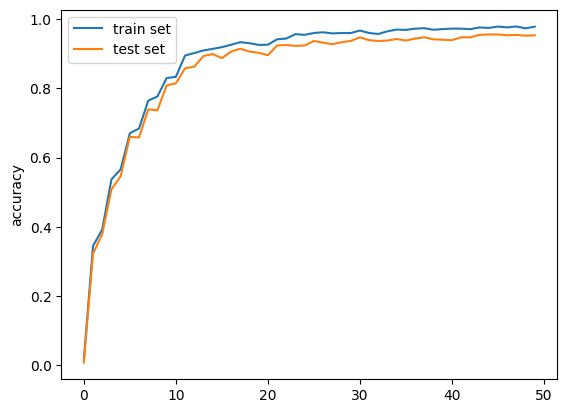

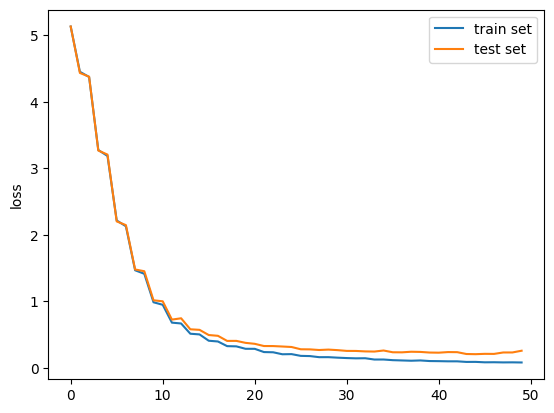

In [19]:
plt.plot(A_Train, label='train set')
plt.plot(A_Test, label='test set')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(L_Train, label='train set')
plt.plot(L_Test, label='test set')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
idx = np.random.choice(len(test_dataset))

x = test_dataset[idx][0]
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {test_dataset[idx][1]}\n')


out_ = model(x.view(1, 1, 28, 28)).detach().flatten()
prob = F.softmax(out_, dim=0)
pred = prob.argmax().item()
print(f'predicted label = {pred}\n')

plt.stem(np.arange(10), prob)
plt.ylabel('probability')
plt.xlabel('class labels')
plt.show()

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 40.5 MB/s eta 0:00:00
